In [1]:
# pip install ipympl

In [1]:
from IPython.display import display, HTML, clear_output
display(HTML("<style>table { width:80% !important; margin-left: 0 !important; font-size:15px !important;} table th, table td {text-align: left !important;}</style>"))

# Overview

- Simulate the scenario of personalizing news content to users on a site, using CB. 
- The goal is to maximize user engagement quantified by measuring click through rate (CTR).

## Scenario set up

- Two website visitors: **Tom** and **Anna**
- Each of them may visit the website either in the morning or in the afternoon

### In CB settings, a data point consists of 4 components:
- **Context:** `(user, time_of_day)`
- **Actions:** `["politics", "sports", "music", "food", "finance", "health", "camping"]`
- **Probability of chosen action**
- **Reward of chosen action:** `click - 1, no click - 0`

## Import dependencies

In [2]:
import vowpalwabbit
from vowpalwabbit import Workspace
import random
import pandas as pd

## Utils

In [3]:
%matplotlib widget

def new_ax():
    import matplotlib.pyplot as plt
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
    ax1.set_xlabel("iterations", fontsize=13)
    ax1.set_ylabel("ctr", fontsize=13)
    ax1.set_ylim([0,1])
    
    ax2.set_xlabel("iterations", fontsize=13)
    ax2.set_ylabel("probs", fontsize=13)
    ax2.set_ylim([0,1])
    
    return fig, ax1, ax2

def plot_ctr(ctr, tom_probs, anna_probs, do_learn=False, ax1=None, ax2=None):
    import matplotlib.pyplot as plt

    if ax1 is None or ax2 is None:
        fig, ax1, ax2 = new_ax()

    if do_learn:
        ax1.plot(ctr, '#415ebf', label='with_learning')
        ax2.plot(pd.Series(tom_probs).rolling(100).mean(), '#415ebf', label='tom')
        ax2.plot(pd.Series(anna_probs).rolling(100).mean(), '#ff3ab0', label='anna')
    else:
        ax1.plot(ctr, '#ff3ab0', label='without_learning')
        
    ax1.legend(loc="upper right")
    ax2.legend(loc="upper right")


In [4]:
 def build_vw_example(context, actions, chosen_action_index=None, reward=None, prob=None):
    import numbers

    assert chosen_action_index is not None or (reward is None and prob is None), (chosen_action_index, reward, prob)

    exarray = []
    exarray.append(f"shared {str(context)}") 
    for k, a in enumerate(actions):
        label = ''
        if chosen_action_index is not None:
            if k == chosen_action_index:
                assert isinstance(reward, numbers.Number), reward
                cost = -reward
                label += f"0:{cost}:{prob}"

        exarray.append(f"{label} {str(a)}")

    return '\n'.join(exarray)

In [5]:
class ExampleBuilder:
    class Features:
        def __init__(self, categorical={}, numerical={}):
            self.categorical = categorical
            self.numerical = numerical
            
        def __str__(self):
            import numbers
            reserved = set(':=|\n ')
            
            exstr = ""
            for key, value in self.categorical.items():
                assert not any(c in reserved for c in key), key
                assert not any(c in reserved for c in value), value
                exstr += f"{key}={value} "
            for key, value in self.numerical.items():
                assert not any(c in reserved for c in key), key
                assert isinstance(value, numbers.Number), value
                exstr += f"{key}:{value} "                  
            return exstr[:-1]
            
    def __init__(self, namespaces={}):
        self.namespaces = namespaces
    
    def __str__(self):
        reserved = set(':=|\n ')
        exstr = ""
        for ns, feats in self.namespaces.items():
            assert not any(c in reserved for c in ns), ns
            exstr += f"|{ns} {str(feats)}"  
        return exstr

## Set up simulator

In [6]:
class Simulator:
    def __init__(self, prefs={}, seed=888, n_bad_features=0):
        import random

        self.random = random.Random(seed)
        self.users = ['Tom', 'Anna']
        self.times_of_day = ['morning', 'afternoon']
        self.articles = ["politics", "sports", "music", "food", "finance", "health", "camping"]
        
        self.actions = [
            ExampleBuilder(
                namespaces={
                    'Action': ExampleBuilder.Features(
                        categorical={'article': k},
                        numerical={f'f{i}': self.random.random() for i in range(int(n_bad_features))}
                    )
                }
            ) 
            for k in self.articles
        ]
        
        self.prefs = prefs # Ground truth user preference

    def _choose_user(self):
        return self.random.choice(self.users)
    
    def _choose_time_of_day(self):
        return self.random.choice(self.times_of_day)
    
    def get_reward(self, context, action_index):
        user = context.namespaces['User'].categorical['user']
        time_of_day = context.namespaces['User'].categorical['time_of_day']
        return self.prefs[user][time_of_day] == self.articles[action_index]
    
    def sample_context(self):
        return ExampleBuilder(
            namespaces = { 
                'User': ExampleBuilder.Features(
                    categorical = { 'user': self._choose_user(), 'time_of_day': self._choose_time_of_day() }
                )
            })
    
    def sample_instance(self):
        return self.sample_context(), self.actions

### VW example format

In [7]:
def show_vw_example(chosen_action_index=None, reward=None, prob=None):
    sim = Simulator()
    context, actions = sim.sample_instance()
    return build_vw_example(context, actions, chosen_action_index, reward, prob)
    
print(show_vw_example())

shared |User user=Tom time_of_day=afternoon
 |Action article=politics
 |Action article=sports
 |Action article=music
 |Action article=food
 |Action article=finance
 |Action article=health
 |Action article=camping


#### CB label format

```
<action>:<cost>:<probability>
```

In [8]:
print(show_vw_example(0, 1, 0.2))

shared |User user=Tom time_of_day=afternoon
0:-1:0.2 |Action article=politics
 |Action article=sports
 |Action article=music
 |Action article=food
 |Action article=finance
 |Action article=health
 |Action article=camping


We will instantiate a CB learner in VW and then simulate Tom and Anna’s website visits num_iterations number of times. In each visit, we:

- Decide between Tom and Anna

- Decide time of day

- Pass context i.e. (user, time of day) to learner to get action i.e. article recommendation and probability of choosing action

- Receive reward i.e. see if user clicked or not. Remember that cost is just negative reward.

- Format context, action, probability, reward in VW format

- Learn from the example

    -VW reduces a CB problem to a cost sensitive multiclass classification problem.

In [9]:
def update_stats(context, articles, prefs, pred, tom_probs, anna_probs):
    user = context.namespaces['User'].categorical['user']
    time_of_day = context.namespaces['User'].categorical['time_of_day']

    if user == 'Tom':
        tom_probs.append(pred[articles.index(prefs[user][time_of_day])])
    elif user == 'Anna':
        anna_probs.append(pred[articles.index(prefs[user][time_of_day])])
        

In [10]:
def run_sim(pref_list, T=5000, seed=98678, do_learn=True, exploration='', n_bad_features=0, ax1=None, ax2=None, **kwargs):
    import numpy as np
    
    vw = Workspace(arg_list=exploration.split(' '), **kwargs)

    rstate = np.random.RandomState(seed=seed); seed += 1
    
    reward_sum = 0.0
    ctr = []
    
    tom_probs = []
    anna_probs = []

    for batch_idx, prefs in enumerate(pref_list):
        sim = Simulator(prefs, seed, n_bad_features)
        
        for i in range(1, T + 1):
            context, actions = sim.sample_instance()
            vw_predict_example = build_vw_example(context, actions)
            
            pred = vw.predict(vw_predict_example)
            pred /= np.sum(pred) # normalize the predictions

            update_stats(context, sim.articles, prefs, pred, tom_probs, anna_probs)
            
            # sample a chosen action (simulate online policy)
            chosen_action = rstate.choice(len(actions), p=pred)

            reward = sim.get_reward(context, chosen_action)

            reward_sum += reward
            
            ctr.append(reward_sum / (batch_idx * T + i))
            
            if do_learn:
                vw_learn_example = build_vw_example(context, actions, chosen_action, reward, pred[chosen_action])
                vw.learn(vw_learn_example)
    vw.finish()

    plot_ctr(ctr, tom_probs, anna_probs, do_learn=do_learn, ax1=ax1, ax2=ax2)


## Scenario 1 - User with stationary preference

|                |                Morning                |                Afternoon                |
| :------------: | :-----------------------------------: | :-------------------------------------: |
|   **Tom**      |                Politics               |                  Music                  |
|  **Anna**      |                Sports                 |                 Politics                |

In [11]:
def run_scenario_1(vw_args):
    pref_list = [
        {
            'Tom': {
                'morning': 'politics',
                'afternoon': 'music'
            },
            'Anna': {
                'morning': 'sports',
                'afternoon': 'politics'
            }
        }
    ]
    
    _, ax1, ax2 = new_ax()
    run_sim(pref_list, ax1=ax1, ax2=ax2, **vw_args)
    run_sim(pref_list, do_learn=False, ax1=ax1, ax2=ax2, **vw_args)

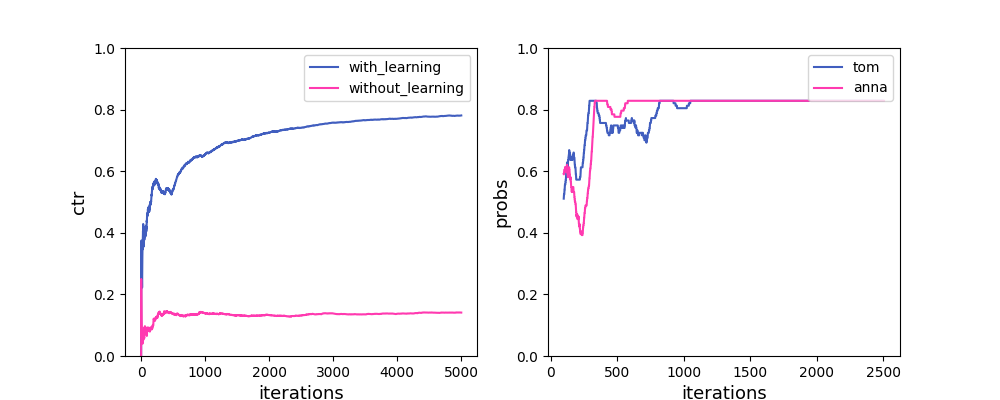

In [12]:
vw_args = {
    'cb_explore_adf': True,
    'q': ['UA'],
    'epsilon': 0.2,
    'quiet': True
}

run_scenario_1(vw_args)

### Interactions

- `'q': ['UA']` is supplied in VW arguments
- Tells VW to create additional features which are the features in the **(U)ser** namespace and **(A)ction** namespaces multiplied together
-  This allows us to learn the interaction between when certain actions are good in certain times of days and for particular users

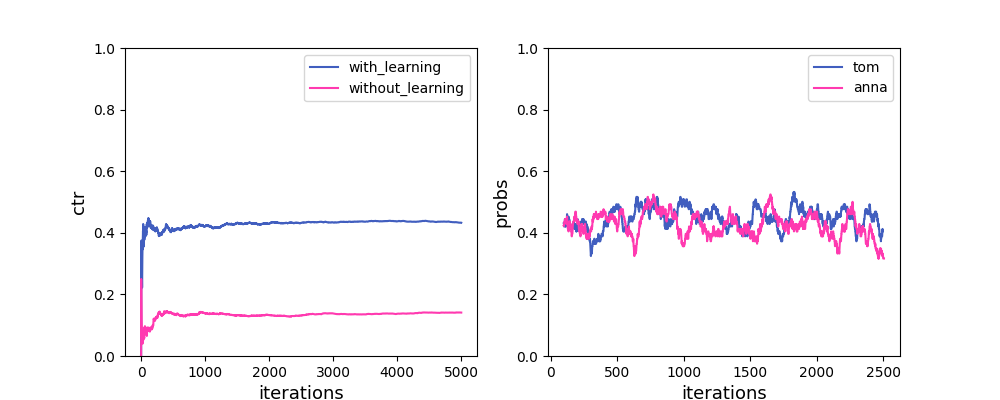

In [13]:
vw_args = {
    'cb_explore_adf': True,
    'epsilon': 0.2,
    'quiet': True
}

run_scenario_1(vw_args)

## Scenario 2 - User with non-stationary preference

### Tom

|                Morning                |                Afternoon                |
| :-----------------------------------: | :-------------------------------------: |
|                Politics               |                  Music                  |
|                Politics               |                  Sports                 |

### Anna
|                Morning                |                Afternoon                |
| :-----------------------------------: | :-------------------------------------: |
|                Sports                 |                Politics                 |
|                Sports                 |                  Sports                 |

In [14]:
def run_scenario_2(vw_args):
    pref_list = [
        {
            'Tom': {
                'morning': 'politics',
                'afternoon': 'music'
            },
            'Anna': {
                'morning': 'sports',
                'afternoon': 'politics'
            }
        },
        {
            'Tom': {
                'morning': 'politics',
                'afternoon': 'sports'
            },
            'Anna': {
                'morning': 'sports',
                'afternoon': 'sports'
            }
        }
    ]

    _, ax1, ax2 = new_ax()
    run_sim(pref_list, ax1=ax1, ax2=ax2, **vw_args)
    run_sim(pref_list, do_learn=False, ax1=ax1, ax2=ax2, **vw_args)

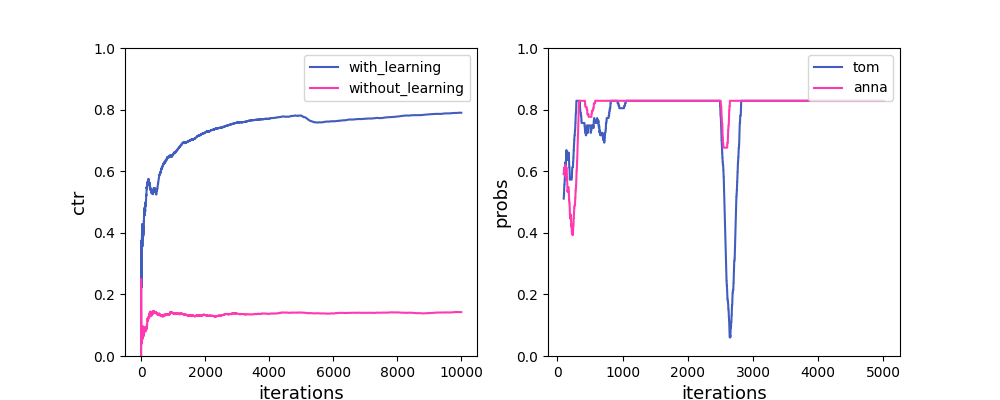

In [15]:
vw_args = {
    'cb_explore_adf': True,
    'q': ['UA'],
    'epsilon': 0.2,
    'quiet': True
}

run_scenario_2(vw_args)

## Scenario 3 - User likes new action

### Tom

|                Morning                |                Afternoon                |
| :-----------------------------------: | :-------------------------------------: |
|                Politics               |                  Music                  |
|                Politics               |                   Food                  |

### Anna
|                Morning                |                Afternoon                |
| :-----------------------------------: | :-------------------------------------: |
|                Sports                 |                Politics                 |
|                 Food                  |                  Sports                 |

In [16]:
def run_scenario_3(vw_args):
    pref_list = [
        {
            'Tom': {
                'morning': 'politics',
                'afternoon': 'music'
            },
            'Anna': {
                'morning': 'sports',
                'afternoon': 'politics'
            }
        },
        {
            'Tom': {
                'morning': 'politics',
                'afternoon': 'food'
            },
            'Anna': {
                'morning': 'food',
                'afternoon': 'sports'
            }
        }
    ]
    
    _, ax1, ax2 = new_ax()
    run_sim(pref_list, ax1=ax1, ax2=ax2, **vw_args)
    run_sim(pref_list, do_learn=False, ax1=ax1, ax2=ax2, **vw_args)

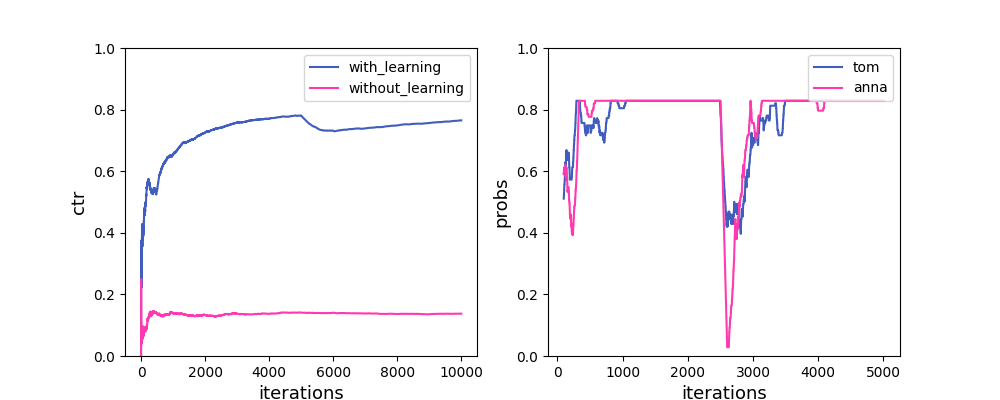

In [17]:
vw_args = {
    'cb_explore_adf': True,
    'q': ['UA'],
    'epsilon': 0.2,
    'quiet': True
}
run_scenario_3(vw_args)

### Try different VW args

In [18]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import numpy as np
import matplotlib.pyplot as plt


In [19]:
def interact(pref_list, explorations=[], n_bad_features=[], **kwargs):
    def _sim(pref_list, n_bad_features, fig, ax1, ax2, **kwargs):
        ax1.clear()
        ax2.clear()
        
        ax1.set_xlabel("iterations", fontsize=13)
        ax1.set_ylabel("ctr", fontsize=13)
        ax1.set_ylim([0, 1])
        
        ax2.set_xlabel("iterations", fontsize=13)
        ax2.set_ylabel("probs", fontsize=13)
        ax2.set_ylim([0, 1])
        
        run_sim(
            pref_list,
            n_bad_features=n_bad_features,
            ax1=ax1,
            ax2=ax2,
            **kwargs
        )
        fig.canvas.draw_idle()
        
    fig, ax1, ax2 = new_ax()
    out = widgets.interactive(_sim, pref_list=fixed(pref_list), n_bad_features=n_bad_features, fig=fixed(fig), ax1=fixed(ax1), ax2=fixed(ax2), 
                              exploration=explorations, **kwargs)

    display(out)

interactive(children=(Dropdown(description='n_bad_features', options=(0, 15, 20), value=0), Dropdown(descripti…

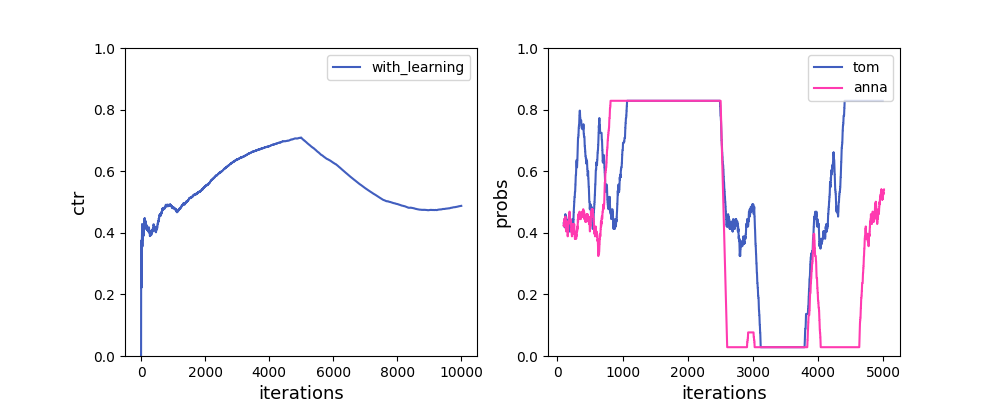

In [20]:
freegrad = widgets.Checkbox(value=False, description="freegrad")
coin = widgets.Checkbox(value=False, description="coin")

learning_rate = widgets.FloatLogSlider(value=0.05, min=-6, max=10, base=2, step=1, description='learning rate')

l1 =  widgets.FloatLogSlider(value=2**(-20), min=-20, max=10, base=2, step=1)

pref_list = [
    {
        'Tom': {
            'morning': 'politics',
            'afternoon': 'music'
        },
        'Anna': {
            'morning': 'sports',
            'afternoon': 'politics'
        }
    },
    {
        'Tom': {
            'morning': 'politics',
            'afternoon': 'food'
        },
        'Anna': {
            'morning': 'food',
            'afternoon': 'sports'
        }
    }
]
    
interact(
    pref_list=pref_list, T=fixed(5000), seed=fixed(98678), do_learn=fixed(True),
    explorations=[
        '--epsilon 0.2', 
        '--bag 3', 
        '--bag 3 --epsilon 0.05', 
        '--squarecb' , 
        '--squarecb --gamma_scale 0',
    ],
    n_bad_features=[0, 15, 20],
    cb_explore_adf=fixed(True),
    quiet=fixed(True),
    q=['UA', '::'],
    learning_rate=learning_rate,
    freegrad=freegrad,
    coin=coin,
    l1=l1
)

In [ ]:
# l1 - 15 bad feature, q::, learning_rate 4, l1 0.00000763